🎯 Week 6 Goal
Build a tuned multi-class classifier (Iris by default; switchable to Wine), compare models with proper 5-fold cross-validation, and generate a recruiter-ready README snippet (+ optional saved model).
Part A — Setup & Utilities
Cell A1 — Imports & helpers
Purpose: Load libs, set RNG seed, and define tiny helpers for CV summaries + safe markdown.

In [1]:
# === Cell A1: imports & helpers ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV, cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform  # for randomized search

RNG_SEED = 42
np.random.seed(RNG_SEED)

def print_cv_summary(name, scores, higher_is_better=True):
    mean, std = np.mean(scores), np.std(scores)
    arrow = "↑" if higher_is_better else "↓"
    print(f"{name}: {mean:.4f} ± {std:.4f} {arrow} (cv={len(scores)})")

def df_to_md(df):
    """Safe markdown: tries DataFrame.to_markdown, falls back to to_string."""
    try:
        return df.to_markdown(index=False)
    except Exception:
        return df.to_string(index=False)


Part B — Data loading & split
Cell B1 — Choose dataset (Iris/Wine), load, stratified split
Purpose: Pick dataset, create X/y, do a stratified train/test split, and define a 5-fold CV splitter.

In [3]:
# === Cell B1: dataset choice + split ===
from sklearn.datasets import load_iris, load_wine

DATASET = "iris"  # change to "wine" to try the Wine dataset

data = load_iris(as_frame=True) if DATASET == "iris" else load_wine(as_frame=True)
df = data.frame.copy()
x = df.drop(columns=["target"])
y = df["target"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, stratify=y, random_state=RNG_SEED
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

print("Shapes:", x_train.shape, x_test.shape)
print("Classes:", list(data.target_names))


Shapes: (112, 4) (38, 4)
Classes: ['setosa', 'versicolor', 'virginica']


Part C — Baseline model
Cell C1 — Logistic Regression baseline (pipeline + multi-metric CV + test)
Purpose: Establish a strong, properly-scaled baseline; report CV Accuracy/F1-macro/ROC-AUC(ovr) and test metrics with a normalized confusion matrix.

Baseline ACC:       0.9648 ± 0.0508 ↑ (cv=5)
Baseline F1_macro:  0.9638 ± 0.0528 ↑
Baseline ROC-AUC:   0.9946 ± 0.0067 ↑ (ovr)
Test Accuracy: 0.9210526315789473
Test F1_macro: 0.9229629629629629
Test ROC-AUC(ovr): 0.9958974358974361


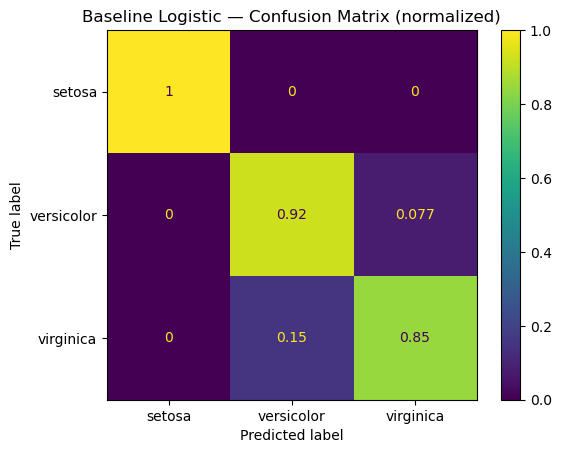

In [5]:
# === Cell C1: Logistic baseline (warning-free) ===
baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=RNG_SEED)),
])

# One CV run, multiple metrics
scoring = {"acc": "accuracy", "f1_macro": "f1_macro", "roc_auc_ovr": "roc_auc_ovr"}
cv_res = cross_validate(baseline_pipe, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

def _m(metric):
    return np.mean(cv_res[f"test_{metric}"]), np.std(cv_res[f"test_{metric}"])

m_acc, s_acc = _m("acc")
m_f1,  s_f1  = _m("f1_macro")
m_auc, s_auc = _m("roc_auc_ovr")
print(f"Baseline ACC:       {m_acc:.4f} ± {s_acc:.4f} ↑ (cv={cv.get_n_splits()})")
print(f"Baseline F1_macro:  {m_f1:.4f} ± {s_f1:.4f} ↑")
print(f"Baseline ROC-AUC:   {m_auc:.4f} ± {s_auc:.4f} ↑ (ovr)")

# Fit once on train, evaluate on test
baseline_pipe.fit(x_train, y_train)
proba = baseline_pipe.predict_proba(x_test)
pred  = baseline_pipe.predict(x_test)

print("Test Accuracy:", accuracy_score(y_test, pred))
print("Test F1_macro:", f1_score(y_test, pred, average="macro"))
print("Test ROC-AUC(ovr):", roc_auc_score(y_test, proba, multi_class="ovr"))

try:
    class_names = list(data.target_names)
except Exception:
    class_names = None

ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=class_names, normalize="true")
plt.title("Baseline Logistic — Confusion Matrix (normalized)")
plt.show()


Part D — KNN tuning (GridSearch)
Cell D1 — GridSearchCV for KNN
Purpose: Tune n_neighbors, weights, and p to maximize macro-F1; evaluate on test with confusion matrix.

KNN best (cv F1_macro): 0.9820613373554551
KNN best params: {'clf__n_neighbors': 16, 'clf__p': 2, 'clf__weights': 'uniform'}
KNN Test Acc: 0.9736842105263158
KNN Test F1_macro: 0.974320987654321
KNN Test ROC-AUC(ovr): 0.9938461538461539


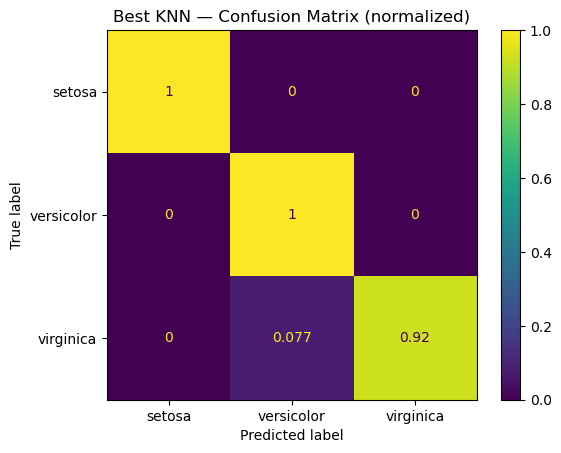

In [7]:
# === Cell D1: KNN tuning (GridSearchCV) ===
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

param_grid_knn = {
    "clf__n_neighbors": list(range(1, 31)),   # shrink range for speed if needed
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # Manhattan vs Euclidean
}

grid_knn = GridSearchCV(
    knn_pipe, param_grid_knn, cv=cv,
    scoring="f1_macro", n_jobs=-1, refit=True, verbose=0
)
grid_knn.fit(x_train, y_train)

print("KNN best (cv F1_macro):", grid_knn.best_score_)
print("KNN best params:", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
pred = best_knn.predict(x_test)
proba = best_knn.predict_proba(x_test)
print("KNN Test Acc:", accuracy_score(y_test, pred))
print("KNN Test F1_macro:", f1_score(y_test, pred, average="macro"))
print("KNN Test ROC-AUC(ovr):", roc_auc_score(y_test, proba, multi_class="ovr"))

ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=list(data.target_names), normalize="true")
plt.title("Best KNN — Confusion Matrix (normalized)")
plt.show()


Part E — SVC (RBF) tuning (RandomizedSearch)
Cell E1 — RandomizedSearchCV for SVC (RBF)
Purpose: Explore SVC with RBF kernel (C, gamma) efficiently; evaluate on test with macro metrics + confusion matrix.

SVC best (cv ROC-AUC ovr): 0.9976984126984128
SVC best params: {'clf__C': 2.5378155082656657, 'clf__gamma': 0.13311216080736885, 'clf__kernel': 'rbf'}
SVC Test Acc: 0.9736842105263158
SVC Test F1_macro: 0.974320987654321
SVC Test ROC-AUC(ovr): 0.997948717948718


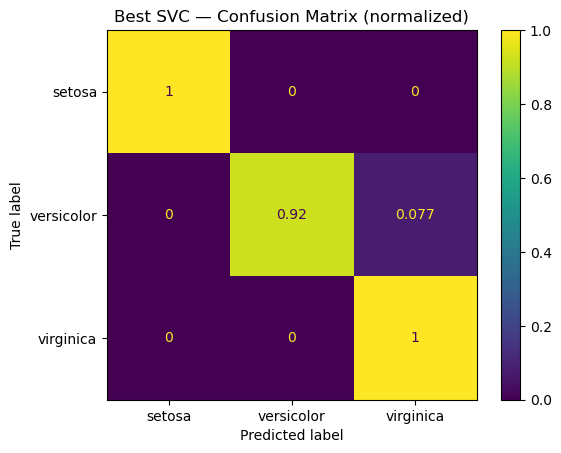

In [9]:
# === Cell E1: SVC tuning (RandomizedSearchCV) ===
svc_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=RNG_SEED))
])

param_dist_svc = {
    "clf__C": loguniform(1e-2, 1e2),
    "clf__gamma": loguniform(1e-3, 1e0),
    "clf__kernel": ["rbf"]
}

rand_svc = RandomizedSearchCV(
    svc_pipe, param_distributions=param_dist_svc, n_iter=25,
    cv=cv, scoring="roc_auc_ovr", n_jobs=-1, random_state=RNG_SEED, refit=True, verbose=0
)
rand_svc.fit(x_train, y_train)

print("SVC best (cv ROC-AUC ovr):", rand_svc.best_score_)
print("SVC best params:", rand_svc.best_params_)

best_svc = rand_svc.best_estimator_
pred = best_svc.predict(x_test)
proba = best_svc.predict_proba(x_test)
print("SVC Test Acc:", accuracy_score(y_test, pred))
print("SVC Test F1_macro:", f1_score(y_test, pred, average='macro'))
print("SVC Test ROC-AUC(ovr):", roc_auc_score(y_test, proba, multi_class='ovr'))

ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=list(data.target_names), normalize="true")
plt.title("Best SVC — Confusion Matrix (normalized)")
plt.show()


Part F — Leaderboard & Save (read-only-safe)
Cell F0 — Pick a writable output directory
Purpose: Find a folder you can write to (project → home → /tmp fallback), store as OUTPUT_DIR.

In [10]:
# === Cell F0: writable OUTPUT_DIR ===
import os, tempfile

def get_writable_dir(preferred="models_week6"):
    candidates = [
        os.path.join(os.getcwd(), preferred),                  # current folder
        os.path.expanduser(f"~/{preferred}"),                  # home
        os.path.join(tempfile.gettempdir(), preferred),        # /tmp
    ]
    for path in candidates:
        try:
            os.makedirs(path, exist_ok=True)
            testfile = os.path.join(path, ".write_test")
            with open(testfile, "w") as f:
                f.write("ok")
            os.remove(testfile)
            return path
        except Exception:
            continue
    raise OSError(f"No writable dir found among: {candidates}")

OUTPUT_DIR = get_writable_dir("models_week6")
print("Using OUTPUT_DIR:", OUTPUT_DIR)


Using OUTPUT_DIR: /Users/vicev/models_week6


Cell F1 — Build leaderboard (CV + test) and save CSV (optional)
Purpose: Compare baseline vs tuned models fairly (same CV splitter); save CSV in OUTPUT_DIR if possible.

In [13]:
# === Cell F1: leaderboard (CV + test) — safe writes ===
import joblib, os

candidates = {
    "Baseline_LogReg": baseline_pipe,
    "Best_KNN": best_knn,
    "Best_SVC": best_svc
}

rows = []
for name, est in candidates.items():
    cv_f1 = cross_val_score(est, x_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
    est.fit(x_train, y_train)
    pred = est.predict(x_test)
    proba = est.predict_proba(x_test)
    rows.append({
        "model": name,
        "cv_f1_macro_mean": cv_f1.mean(),
        "cv_f1_macro_std": cv_f1.std(),
        "test_acc": accuracy_score(y_test, pred),
        "test_f1_macro": f1_score(y_test, pred, average="macro"),
        "test_roc_auc_ovr": roc_auc_score(y_test, proba, multi_class="ovr")
    })

leaderboard = pd.DataFrame(rows).sort_values("cv_f1_macro_mean", ascending=False)
leaderboard

# Optional: save leaderboard CSV
try:
    lb_path = os.path.join(OUTPUT_DIR, f"leaderboard_week6_{DATASET}.csv")
    leaderboard.to_csv(lb_path, index=False)
    print("Saved leaderboard ->", lb_path)
except Exception as e:
    print("Could not save leaderboard (skipping):", e)


Saved leaderboard -> /Users/vicev/models_week6/leaderboard_week6_iris.csv


Cell F2 — Save the winner model (optional)
Purpose: Persist the top model into OUTPUT_DIR using a consistent filename; won’t crash if FS is read-only.

In [14]:
# === Cell F2: save winner (optional) — safe writes ===
top = leaderboard.iloc[0]
winner_name = top["model"]
winner = {"Baseline_LogReg": baseline_pipe, "Best_KNN": best_knn, "Best_SVC": best_svc}[winner_name]

out_path = os.path.join(OUTPUT_DIR, f"{winner_name}_{DATASET}.pkl")
try:
    joblib.dump(winner, out_path)
    print(f"Saved model -> {out_path}")
except Exception as e:
    print("Could not save model (skipping):", e)

top


Saved model -> /Users/vicev/models_week6/Best_KNN_iris.pkl


model               Best_KNN
cv_f1_macro_mean    0.982061
cv_f1_macro_std     0.021972
test_acc            0.973684
test_f1_macro       0.974321
test_roc_auc_ovr    0.993846
Name: 1, dtype: object

Part G — Generate README snippet
Cell G1 — Create README_Week6.md and print it to screen
Purpose: Write a recruiter-friendly Markdown report to OUTPUT_DIR and also print it so you can copy/paste if writing fails.

In [15]:
# === Cell G1: write README_Week6.md — safe writes + console print ===
from datetime import datetime

md = f"""# Week 6 — {DATASET.title()} Classifier (Tuned)

**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M')}
**Dataset:** {DATASET.title()} (scikit-learn)

## Methods
- Pipeline: StandardScaler + estimator
- CV: StratifiedKFold (5-fold)
- Tuning:
  - KNN: n_neighbors, weights, p (GridSearchCV)
  - SVC (RBF): C, gamma (RandomizedSearchCV)

## Leaderboard (sorted by CV F1-macro)
{df_to_md(leaderboard.round(4))}

**Winner:** {winner_name}

## Artifacts
- Saved model: `{OUTPUT_DIR}/{winner_name}_{DATASET}.pkl`
- Leaderboard CSV: `{OUTPUT_DIR}/leaderboard_week6_{DATASET}.csv`
"""

readme_path = os.path.join(OUTPUT_DIR, "README_Week6.md")
try:
    with open(readme_path, "w", encoding="utf-8") as f:
        f.write(md)
    print("Wrote README ->", readme_path)
except Exception as e:
    print("Could not write README (copy from below):", e)

print("\n----- README_Week6.md (copy/paste) -----\n")
print(md)


Wrote README -> /Users/vicev/models_week6/README_Week6.md

----- README_Week6.md (copy/paste) -----

# Week 6 — Iris Classifier (Tuned)

**Date:** 2025-09-15 23:47
**Dataset:** Iris (scikit-learn)

## Methods
- Pipeline: StandardScaler + estimator
- CV: StratifiedKFold (5-fold)
- Tuning:
  - KNN: n_neighbors, weights, p (GridSearchCV)
  - SVC (RBF): C, gamma (RandomizedSearchCV)

## Leaderboard (sorted by CV F1-macro)
| model           |   cv_f1_macro_mean |   cv_f1_macro_std |   test_acc |   test_f1_macro |   test_roc_auc_ovr |
|:----------------|-------------------:|------------------:|-----------:|----------------:|-------------------:|
| Best_KNN        |             0.9821 |            0.022  |     0.9737 |          0.9743 |             0.9938 |
| Baseline_LogReg |             0.9638 |            0.0528 |     0.9211 |          0.923  |             0.9959 |
| Best_SVC        |             0.9638 |            0.0528 |     0.9737 |          0.9743 |             0.9979 |

**Winner:** 